[![CyVers](https://i.imgur.com/yyhmZET.png)](https://www.cyvers.ai/)

# BlockChain Attack Data Set - Exploratory Data Analysis (EDA)

> Notebook by:
> - Royi Avital Royi@cyvers.ai

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 30/06/2022 | Royi Avital | First version                                                      |
| 0.2.000 | 25/07/2022 | Royi Avital | Added model selection and visualization of features                |
| 0.3.000 | 31/07/2022 | Royi Avital | Added a view of feature importance (Should be moved to a funciton) |
|         |            |             |                                                                    |

In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet001'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 35
The number of rows (Samples): 379887, The number of columns: 19, number of unique sender id's: (35,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level'],
      dtype='object') with 19 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
282934,0x20df0e830aedd2dabe878911372d4009d3aaddb89601...,NaN,2019-09-06 10:45:34+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0x9df7c98c933a0cb409606a3a24b1660a70283542,Wallet,20.000000,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,19.984945,1.452000e-08,221310.0,221310,NaN,NaN,NaN,0,NaN
282933,0x716f314c669b02083051da4d37485cce315f70ca0eb4...,NaN,2019-09-06 15:59:27+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0xdbc9454541a32fc0cc1b76cfc674a76aab6233a9,Wallet,500.000000,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,499.623629,9.700000e-09,206310.0,206310,NaN,NaN,NaN,0,NaN
282932,0x23bb5e62a918a49fbf384640d0d4c52f6b354a9808dd...,NaN,2019-09-06 16:03:40+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0xdbc9454541a32fc0cc1b76cfc674a76aab6233a9,Wallet,500.000000,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,499.623629,8.000000e-09,185854.0,185854,NaN,NaN,NaN,0,NaN
282931,0x95ea05a1881aeb935203c14ea54709ec8f124f57f378...,NaN,2019-09-06 16:14:21+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0xdbc9454541a32fc0cc1b76cfc674a76aab6233a9,Wallet,91.110000,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,91.041418,9.500000e-09,185854.0,185854,NaN,NaN,NaN,0,NaN
282930,0x6eccf7f1b2b319a53d3c9ae536668cbdaf870c2b3680...,NaN,2019-09-06 16:35:34+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0xb1156ef2dc0317f80ebce395806b20cb91dcb5f3,Wallet,500.000000,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,499.623629,1.200000e-08,162869.0,162869,NaN,NaN,NaN,0,NaN
282929,0x88dffac8471abd0f11cb6a508e857506fe13d52ad0a7...,NaN,2019-09-06 17:53:51+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0xb1156ef2dc0317f80ebce395806b20cb91dcb5f3,Wallet,500.008846,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,499.632468,8.976563e-09,185201.0,170201,NaN,NaN,NaN,0,NaN
282928,0x9f8348ada267545e635e599b888be6fe65935f526e97...,NaN,2019-09-06 17:57:31+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0xdbc9454541a32fc0cc1b76cfc674a76aab6233a9,Wallet,10.000000,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,ERC20,1780.055575,8.000000e-09,188716.0,173716,NaN,NaN,NaN,0,NaN
282927,0x367608b2f820673ecdef68c88cd7cbb82ae1208d45e6...,NaN,2019-09-06 18:18:36+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0xdbc9454541a32fc0cc1b76cfc674a76aab6233a9,Wallet,2092.200000,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,2090.625112,6.000000e-09,176310.0,176310,NaN,NaN,NaN,0,NaN
282926,0x24d99ff22999bf14e8692ba45f316d0904b2c39a1df0...,NaN,2019-09-08 03:49:28+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0x4f27eb908eaadfea04f6b66847faabaeb45ecb15,Wallet,50.000003,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,49.962366,7.000000e-09,206084.0,191084,NaN,NaN,NaN,0,NaN
282925,0xc0dc0a7167a211e0585c332f3de23592d28477477633...,NaN,2019-09-08 03:50:44+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0x4f27eb908eaadfea04f6b66847faabaeb45ecb15,Wallet,5.000000,USDx,0xeb269732ab75a6fd61ea60b06fe994cd32a83549,ERC20,4.996236,7.000000e-09,191256.0,191256,NaN,NaN,NaN,0,NaN


# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [10]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
278086,0xe49304cd3edccf32069dcbbb5df7ac3b8678daad34d0...,NaN,2020-04-19 00:58:43+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0x538359785a8d5ab1a741a0ba94f26a800759d91d,Smart Contract,2.159400e-04,imBTC,0x3212b29e33587a00fb1c83346f5dbfa69a458923,ERC20,5.095926e-03,5.100000e-09,711007.0,601944,NaN,NaN,NaN,1,NaN
278085,0xae7d664bdfcc54220df4f18d339005c6faf6e62c9ca7...,NaN,2020-04-19 00:58:55+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0x538359785a8d5ab1a741a0ba94f26a800759d91d,Smart Contract,4.318800e-04,imBTC,0x3212b29e33587a00fb1c83346f5dbfa69a458923,ERC20,1.019185e-02,5.100000e-09,711007.0,515366,NaN,NaN,NaN,1,NaN
278084,0xa0e7c8e933be65854bee69df3816a07be37e108c43bb...,NaN,2020-04-19 00:59:19+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0x538359785a8d5ab1a741a0ba94f26a800759d91d,Smart Contract,8.637600e-04,imBTC,0x3212b29e33587a00fb1c83346f5dbfa69a458923,ERC20,2.038371e-02,5.100000e-09,711007.0,515366,NaN,NaN,NaN,1,NaN
278083,0xf8ed32d4a4aad0b5bb150f7a0d6e95b5d264d6da6c16...,NaN,2020-04-19 00:59:52+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0x538359785a8d5ab1a741a0ba94f26a800759d91d,Smart Contract,1.727520e-03,imBTC,0x3212b29e33587a00fb1c83346f5dbfa69a458923,ERC20,4.076741e-02,5.100000e-09,711007.0,515366,NaN,NaN,NaN,1,NaN
278082,0x2703e317c1e36fc1b557a545f837ab94370c7483f4de...,NaN,2020-04-19 01:02:11+00:00,0x0eee3e3828a45f7601d5f54bf49bb01d1a9df5ea,0x538359785a8d5ab1a741a0ba94f26a800759d91d,Smart Contract,3.455040e-03,imBTC,0x3212b29e33587a00fb1c83346f5dbfa69a458923,ERC20,8.153482e-02,5.100000e-09,711007.0,515366,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277982,0x600373f67521324c8068cfd025f121a0843d57ec8134...,NaN,2022-04-02 11:04:09+00:00,0xea0c959bbb7476ddd6cd4204bdee82b790aa1562,0x8b4c1083cd6aef062298e1fa900df9832c8351b3,Wallet,3.999669e+06,DOLA,0x865377367054516e17014ccded1e7d814edc9ce4,ERC20,4.007352e+06,4.000000e-07,2000000.0,1464734,NaN,NaN,NaN,1,NaN
277983,0x600373f67521324c8068cfd025f121a0843d57ec8134...,NaN,2022-04-02 11:04:09+00:00,0xea0c959bbb7476ddd6cd4204bdee82b790aa1562,0x8b4c1083cd6aef062298e1fa900df9832c8351b3,Wallet,9.403072e+01,WBTC,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,ERC20,4.371996e+06,4.000000e-07,2000000.0,1464734,NaN,NaN,NaN,1,NaN
277985,0x600373f67521324c8068cfd025f121a0843d57ec8134...,NaN,2022-04-02 11:04:09+00:00,0xea0c959bbb7476ddd6cd4204bdee82b790aa1562,0x8b4c1083cd6aef062298e1fa900df9832c8351b3,Wallet,1.588264e+03,ETH,0x0000000000000000000000000000000000000000,NaN,5.481410e+06,4.000000e-07,2000000.0,1464734,NaN,NaN,NaN,1,NaN
77191,0x03ee21b25b7c2c521c860992caab8dd41121389b11a6...,NaN,2022-06-04 08:32:05+00:00,0xa0f6ff6aca3a401766f96356e822d92576a42cc5,0x1079061d37f7f3fd3295e4aad02ece4a3f20de2d,Wallet,1.796000e+01,WETH,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,ERC20,3.180929e+04,4.315453e-08,378497.0,276610,NaN,NaN,NaN,1,NaN


In [11]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    379409
1       478
Name: Label, dtype: int64

In [12]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

35

In [13]:
dfData['Label'].value_counts()

0    379409
1       478
Name: Label, dtype: int64

In [14]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379887 entries, 282934 to 76800
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Transaction ID    379887 non-null  object             
 1   Transaction Time  0 non-null       float64            
 2   Block Time        379887 non-null  datetime64[ns, UTC]
 3   Sender ID         379887 non-null  object             
 4   Receiver ID       379887 non-null  object             
 5   Receiver Type     379887 non-null  object             
 6   Amount            379887 non-null  float64            
 7   Currency          379628 non-null  object             
 8   Currency Hash     379887 non-null  object             
 9   Currency Type     302202 non-null  object             
 10  Amount [USD]      360697 non-null  float64            
 11  Gas Price         379887 non-null  float64            
 12  Gas Limit         379887 non-null  float

In [15]:
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,3.798870e+05,3.606970e+05,3.798870e+05,3.798870e+05,3.798870e+05,0.0,0.0,0.0,379887.000000,0.0
mean,NaN,3.053540e+71,8.249514e+04,8.551992e-08,3.493681e+05,1.991704e+05,NaN,NaN,NaN,0.001258,NaN
std,NaN,1.882048e+74,1.812413e+06,9.503000e-08,5.907884e+05,4.279292e+05,NaN,NaN,NaN,0.035450,NaN
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+04,1.969800e+04,NaN,NaN,NaN,0.000000,NaN
25%,NaN,1.600000e+00,1.943525e+02,2.769152e-08,1.050000e+05,5.217000e+04,NaN,NaN,NaN,0.000000,NaN
50%,NaN,3.343956e+02,2.169640e+03,6.820000e-08,2.000000e+05,1.158770e+05,NaN,NaN,NaN,0.000000,NaN
75%,NaN,9.507346e+03,1.324581e+04,1.158103e-07,3.448300e+05,2.305825e+05,NaN,NaN,NaN,0.000000,NaN
max,NaN,1.160000e+77,5.253215e+08,1.477464e-05,1.206599e+07,9.895111e+06,NaN,NaN,NaN,1.000000,NaN


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [16]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 38731


In [17]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [18]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [19]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [20]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 341156, The number of columns: 19


# Meet the Data

Basic infomration about the data.

In [21]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341156 entries, 282934 to 47270
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   Transaction ID    341156 non-null  object             
 1   Transaction Time  0 non-null       float64            
 2   Block Time        341156 non-null  datetime64[ns, UTC]
 3   Sender ID         341156 non-null  object             
 4   Receiver ID       341156 non-null  object             
 5   Receiver Type     341156 non-null  object             
 6   Amount            341156 non-null  float64            
 7   Currency          340960 non-null  object             
 8   Currency Hash     341156 non-null  object             
 9   Currency Type     263474 non-null  object             
 10  Amount [USD]      341156 non-null  float64            
 11  Gas Price         341156 non-null  float64            
 12  Gas Limit         341156 non-null  float

In [22]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,3.411560e+05,3.411560e+05,3.411560e+05,3.411560e+05,3.411560e+05,0.0,0.0,0.0,341156.000000,0.0
mean,NaN,4.789108e+11,8.722037e+04,8.484216e-08,3.452075e+05,1.923119e+05,NaN,NaN,NaN,0.001363,NaN
std,NaN,1.536976e+14,1.863486e+06,9.470848e-08,5.620883e+05,3.837892e+05,NaN,NaN,NaN,0.036894,NaN
min,NaN,1.000000e-18,1.032324e-18,0.000000e+00,2.100000e+04,1.969800e+04,NaN,NaN,NaN,0.000000,NaN
25%,NaN,1.100000e+00,3.120015e+02,2.700000e-08,1.050000e+05,5.214300e+04,NaN,NaN,NaN,0.000000,NaN
50%,NaN,2.500000e+02,2.719975e+03,6.862871e-08,2.158750e+05,1.231560e+05,NaN,NaN,NaN,0.000000,NaN
75%,NaN,7.656315e+03,1.484666e+04,1.150000e-07,3.542960e+05,2.318450e+05,NaN,NaN,NaN,0.000000,NaN
max,NaN,8.900000e+16,5.253215e+08,1.477464e-05,1.206599e+07,9.895111e+06,NaN,NaN,NaN,1.000000,NaN


In [23]:
# How many times each hacker attacked
dsAttacksAsset = dfData[dfData['Label'] == 1]['Receiver ID'].value_counts()

print(f'There are {dsAttacksAsset.shape[0]} Attackers')
print(dsAttacksAsset.head(len(dsAttacksAsset))) #<! Last ones should be 1

There are 24 Attackers
0x39fb0dcd13945b835d47410ae0de7181d3edf270    83
0x277e851587eb5da22b52a10f4788576e68150277    81
0x941a9e3b91e1cc015702b897c512d265fae88a9c    65
0xeda5066780de29d00dfb54581a707ef6f52d8113    56
0x538359785a8d5ab1a741a0ba94f26a800759d91d    41
0xeaa86ddd49d8907c939413e92888536e4587bd9a    29
0xdcc8a38a3a1f4ef4d0b4984dcbb31627d0952c28    25
0xf224ab004461540778a914ea397c589b677e27bb    17
0xf05ca010d0bd620cc7c8e96e00855dde2c2943df    16
0xc8a65fadf0e0ddaf421f28feab69bf6e2e589963    10
0x6ffe6e183571139636b9479ca65cf99edc6be215     8
0x4fbf7701b3078b5bed6f3e64df3ae09650ee7de5     6
0x8b4c1083cd6aef062298e1fa900df9832c8351b3     4
0xef967ece5322c0d7d26dab41778acb55ce5bd58b     4
0x629e7da20197a5429d30da36e77d06cdf796b71a     3
0x098b716b8aaf21512996dc57eb0615e2383e2f96     3
0x872254d530ae8983628cb1eaafc51f78d78c86d9     2
0x6b0b61323f6d77ef8a1a35d11fa877631d8f67bb     2
0x74487eed1e67f4787e8c0570e8d5d168a05254d4     2
0x2708cace7b42302af26f1ab896111d87faeff92f    

Text(0, 0.5, 'Number of Attackers')

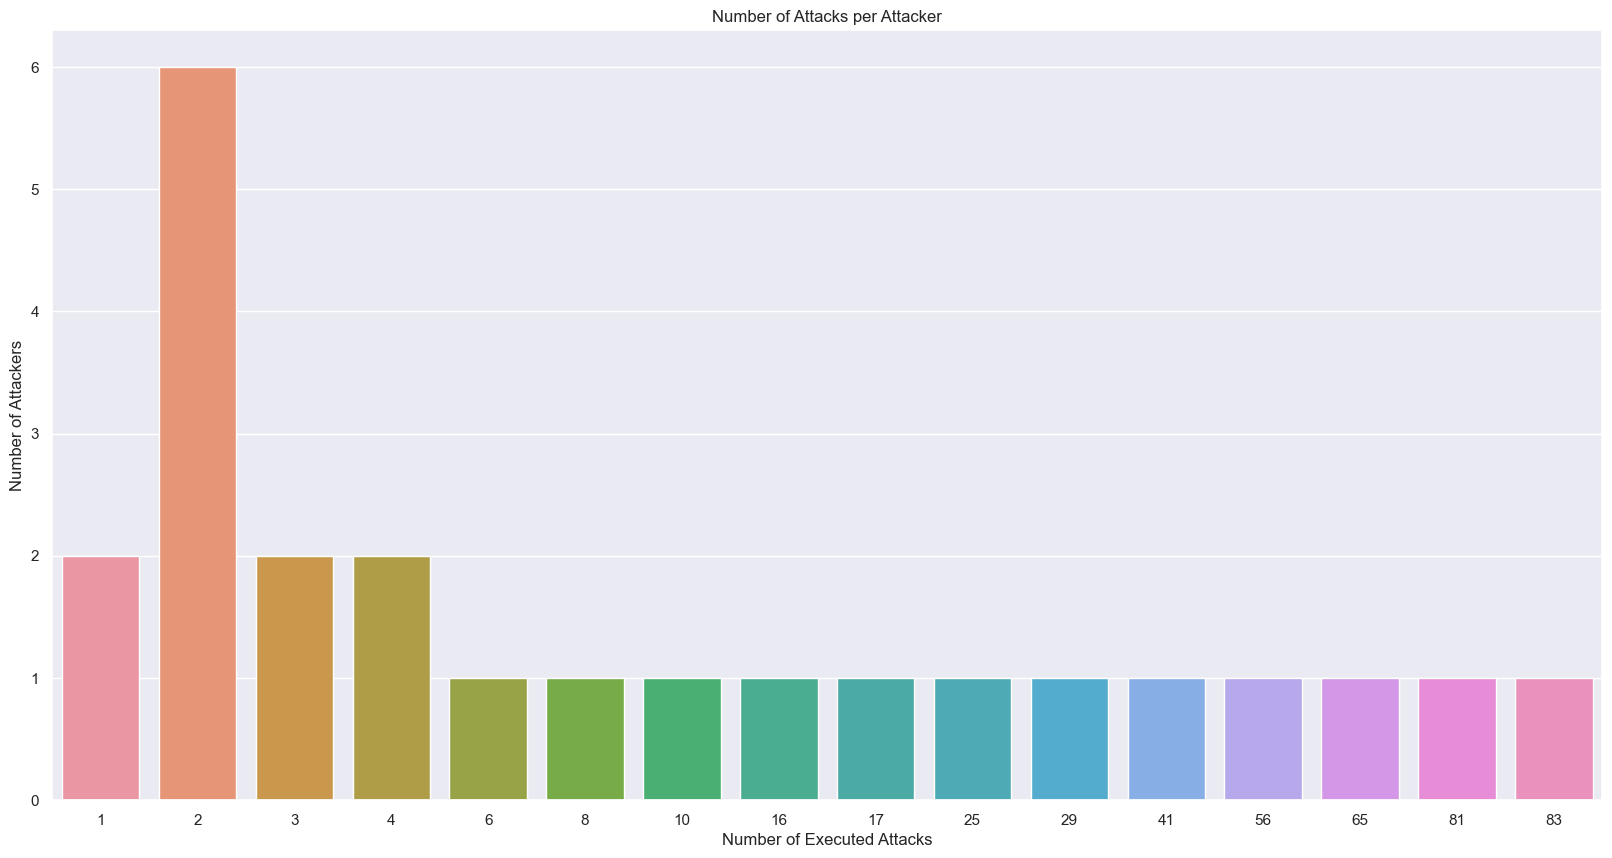

In [24]:
hF, hA = plt.subplots(figsize = (20, 10)) # 
sns.countplot(dsAttacksAsset, ax = hA)
hA.set_title('Number of Attacks per Attacker')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Attackers')

In [25]:
# How many times each asset was attacked?
dsSenderCount = dfData[dfData['Label'] == 1]['Sender ID'].value_counts()

Text(0, 0.5, 'Number of Assets')

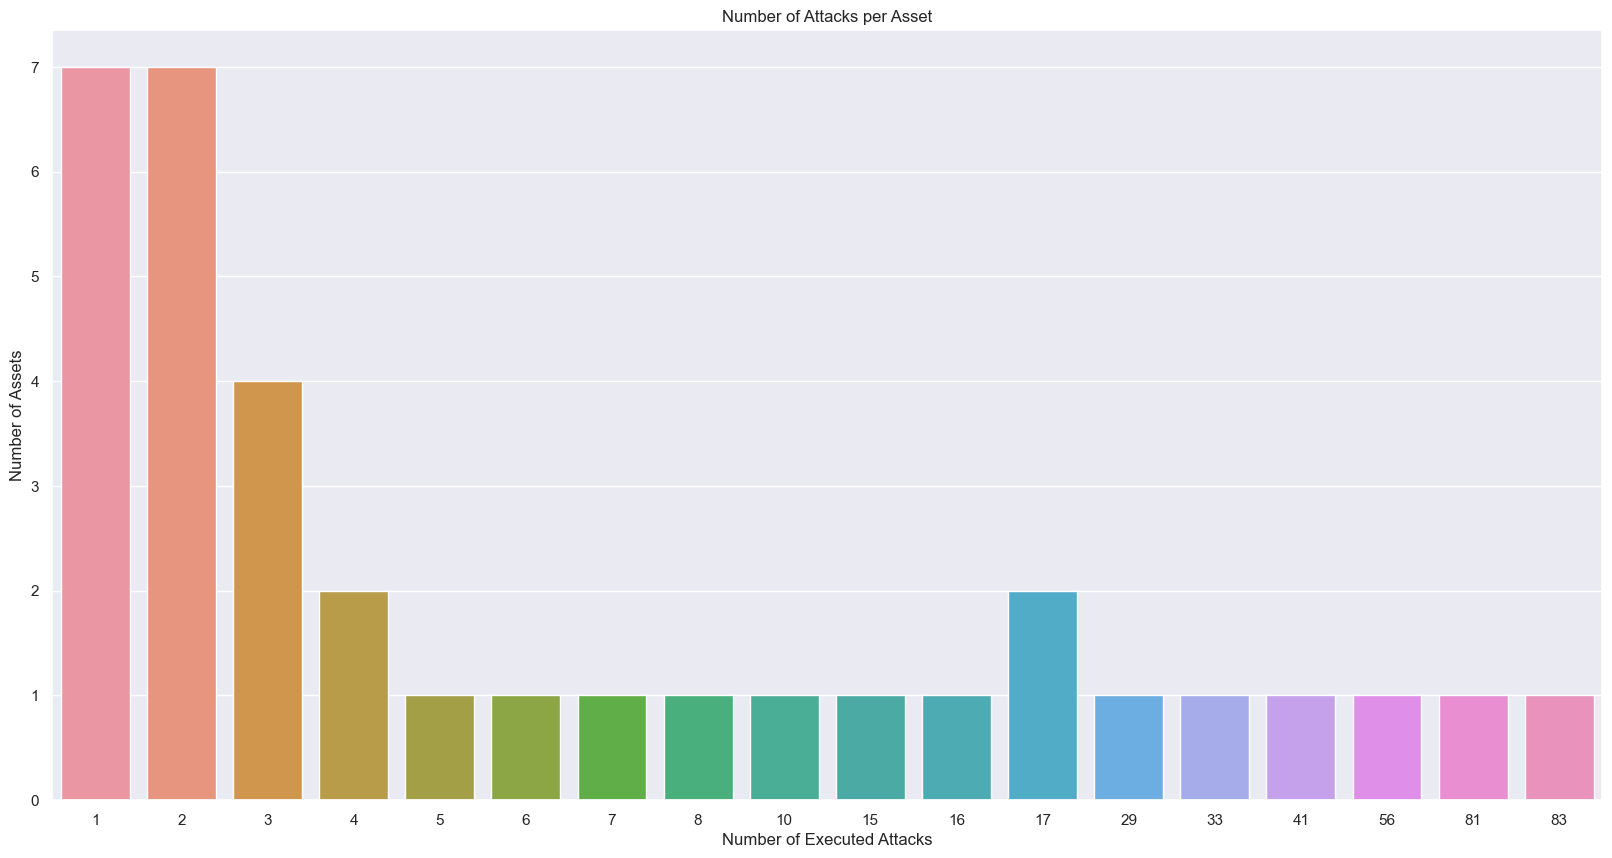

In [26]:
hF, hA = plt.subplots(figsize = (20, 10)) # TODO: Display an histogram (How many assets were attacked 1, 2, ...)
sns.countplot(dsSenderCount, ax = hA)
hA.set_title('Number of Attacks per Asset')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Assets')

In [27]:
# How many different assets each attacker attacked? How many times per asset?
dsAttacksIdAttacker = dfData[dfData['Label'] == 1].groupby(['Receiver ID', 'Sender ID'])['Transaction ID'].count().reset_index(name = 'Number of Attacks')  
dsAttacksIdAttacker.head(40)

,Receiver ID,Sender ID,Number of Attacks
0,0x098b716b8aaf21512996dc57eb0615e2383e2f96,0x1a2a1c938ce3ec39b6d47113c7955baa9dd454f2,3
1,0x0ae1554860e51844b61ae20823ef1268c3949f7c,0x7ea2be2df7ba6e54b1a9c70676f668455e329d29,1
2,0x1079061d37f7f3fd3295e4aad02ece4a3f20de2d,0xa0f6ff6aca3a401766f96356e822d92576a42cc5,2
3,0x2708cace7b42302af26f1ab896111d87faeff92f,0x6e70c88be1d5c2a4c0c8205764d01abe6a3d2e22,1
4,0x2708cace7b42302af26f1ab896111d87faeff92f,0xa43b89d5e7951d410585360f6808133e8b919289,1
5,0x277e851587eb5da22b52a10f4788576e68150277,0xfa6de2697d59e88ed7fc4dfe5a33dac43565ea41,81
6,0x39fb0dcd13945b835d47410ae0de7181d3edf270,0x68b22215ff74e3606bd5e6c1de8c2d68180c85f7,83
7,0x3ddd8b6d092df917473680d6c41f80f708c45395,0xc2704dec22e552164dee240b20b840ea379b878e,1
8,0x4fbf7701b3078b5bed6f3e64df3ae09650ee7de5,0x18d98d452072ac2eb7b74ce3db723374360539f1,5
9,0x4fbf7701b3078b5bed6f3e64df3ae09650ee7de5,0x53461e4fddcc1385f1256ae24ce3505be664f249,1


In [28]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

### SASA vs. SAMA Cases

Definitions:

 * SASA:
 * SAMA:

**Remark**: Move to:

SASASW - Single Asset, Single   Attacks, Single   Wallets  
SAMASW - Single Asset, Multiple Attacks, Single   Wallets (SAMA)  
SAMAMW - Single Asset, Multiple Attacks, Multiple Wallets (SAMA)  

In [29]:
# Analysis of Attack Type
# !!! The function `CalcAttackType()` uses the Pandas extension, hence it should be initialized before!
dsAttackType, dfAttackType = CalcAttackType(dfData)

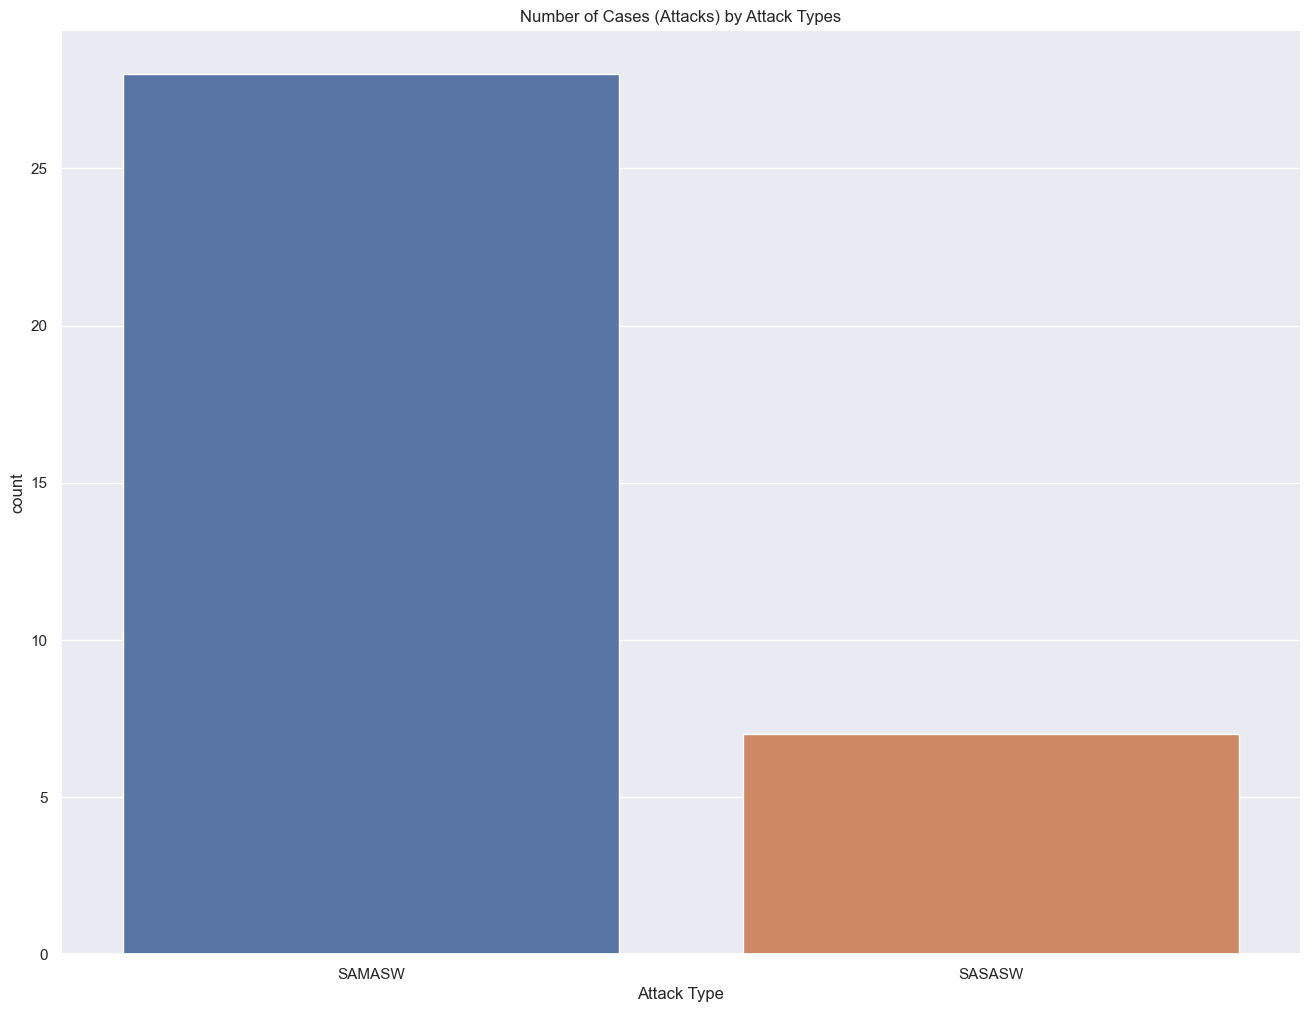

In [30]:
# Display an Histogram of the Attack Types
hF, hA = plt.subplots(figsize = (16, 12))
sns.countplot(x = dfAttackType['Attack Type'], ax = hA)
hA.set_title('Number of Cases (Attacks) by Attack Types')
plt.show()

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [31]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [32]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [33]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [34]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [35]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [36]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [37]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [38]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [39]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [40]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [41]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


## Features Visualization

In [ ]:
numFeatures     = len(lSlctdFeatures)

In [ ]:
# Display the Scatter of the Features

oDropdwon = Dropdown(
    options     = lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

interact(lambda yColName: DisplayScatterFeature(dfData, 'Label', yColName, 'Suspicious'), yColName = oDropdwon)

In [ ]:
# Display the Density of the Features

oDropdwon = Dropdown(
    options     = lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

interact(lambda yColName: DisplayKdeFeature(dfData, yColName, 'Label', 'Suspicious'), yColName = oDropdwon)

## Features Pre Processing (For Training Phase)

In [42]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

In [ ]:
# Pre Processing Data
dfData.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData.fillna(0, inplace = True)
dfX = dfData[lSlctdFeatures].copy()
for catColName in lCatFeatures:
    dfX[catColName], _ =  pd.factorize(dfX[catColName])

In [ ]:
# Input Data for Classifier

lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]

mX = dfX[lNumericalFeatures].to_numpy()
mC = dfX[lCatFeatures].to_numpy()
vY = dfData['Label'].to_numpy()
# Scaling the data
hStdScaler = StandardScaler() #<! Don't touch categorial data
mX = hStdScaler.fit_transform(mX)
mX = np.concatenate((mX, mC), axis = 1)

### Display the PPS Matrix

The idea is to see the relationship between the features not by a linear correlation but by the ability to predict them.

In [ ]:
# Creating the DF for the PPS analysis
dfTmp = dfData[lSlctdFeatures + ['Label']].copy()

for featureName in (lCatFeatures + ['Label']):
    dfTmp[featureName] = pd.Categorical(dfTmp[featureName])  

In [ ]:
# Feature PPS - Which featuers are important?

# Pay attention, cross validation is K-Fold -> Don't over split the data
mPPS = pps.matrix(dfTmp, **{'cross_validation': numCrossValPps, 'random_seed': randomState})[['x', 'y', 'ppscore']].pivot(columns = 'x', index = 'y', values = 'ppscore') #<! We should set `Label` as a categorial variable

# Visualization of PPS
hF, hA = plt.subplots(figsize = (30, 30))
sns.heatmap(mPPS, annot = True, fmt = '.2f', cmap = plt.get_cmap('coolwarm'), cbar = False, vmin = 0, vmax = 1, ax = hA) 

plt.setp(hA.get_xticklabels(), ha = "center", rotation = 45)
plt.setp(hA.get_yticklabels(), rotation = 'horizontal')
hA.set_title('Predictive Power Score (PPS)')

In [ ]:
# Validation the columns are legit
dfX.columns

## Model Training and Evaluation

### Classic Train Test Split

In [ ]:
mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = testSetRatio, random_state = randomState, stratify = vY)

In [ ]:
xgbModel = XGBClassifier(use_label_encoder = False)
xgbModel.fit(mXTrain, vYTrain)
vYPred = xgbModel.predict(mXTest)

In [ ]:
DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)

In [ ]:
dsScoreSumm = GenClassifierSummaryResults(vYTest, vYPred)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary

### K Fold Training

In [ ]:
# Training by Transactions (K-Fold)
hKFoldSplt = StratifiedKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrinIdx, vTestIdx in hKFoldSplt.split(mX, vY):
    mXTrain, mXTest, vYTrain, vYTest = mX[vTrinIdx, :], mX[vTestIdx, :], vY[vTrinIdx], vY[vTestIdx]
    xgbModel = XGBClassifier(use_label_encoder = False)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [ ]:
lTotalFeatures = lNumericalFeatures + lCatFeatures
len(lTotalFeatures)

In [ ]:
dfFeatures = pd.DataFrame(data = list(zip(lTotalFeatures, xgbModel.feature_importances_)), columns = ['Feature Name', 'Feature Importance'])

In [ ]:
hF, hA = plt.subplots(figsize = (32, 8))
sns.barplot(data = dfFeatures, x = 'Feature Name', y = 'Feature Importance', ax = hA)
plt.setp(hA.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
# Pre Processing data to match the text indices
vTetsIdxDf = dfData.index[vTestIdx]
dAttackTypeName = {}
for attackTypeEnum in AttackType:
    dAttackTypeName[attackTypeEnum.value] = attackTypeEnum.name


In [ ]:
GenClassifierSummaryResultsGrp(vYTest, vYPred, vGrpLabel = dsAttackType[vTetsIdxDf].to_numpy(), dGrpName = dAttackTypeName) #<! Results don't look reasonable

In [ ]:
# Training by Files (K-Fold)
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX[vTrainIdx, :], mX[vTestIdx, :], vY[vTrainIdx], vY[vTestIdx]
    xgbModel = XGBClassifier(use_label_encoder = False)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

### K-fold training, using categorical variables (EXPERIMENT)

In [43]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [44]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [45]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


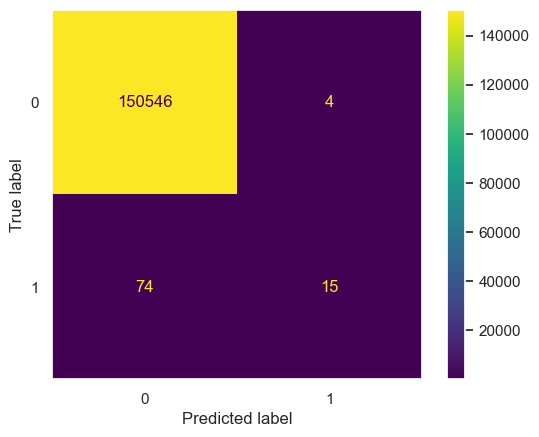

Accuracy         0.999482
F1               0.277778
Precision        0.789474
Recall           0.168539
ROC AUC Score    0.584256
dtype: float64


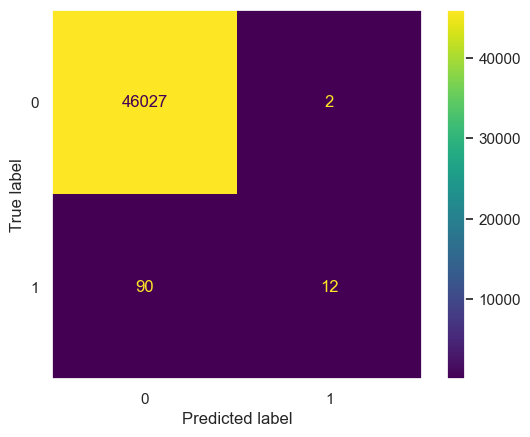

Accuracy         0.998006
F1               0.206897
Precision        0.857143
Recall           0.117647
ROC AUC Score    0.558802
dtype: float64


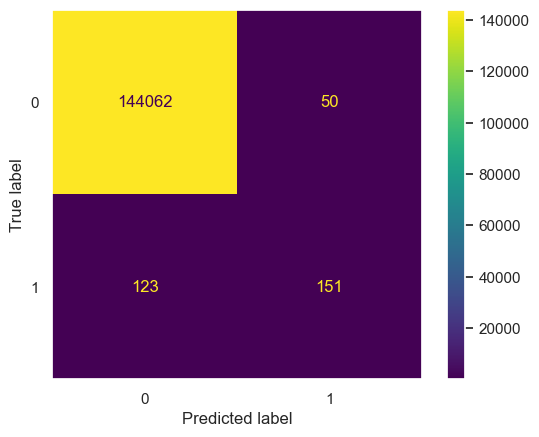

Accuracy         0.998802
F1               0.635789
Precision        0.751244
Recall           0.551095
ROC AUC Score    0.775374
dtype: float64


In [46]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

### Data Split

In [ ]:

if trainMode == TRAIN_BY_FILES:
    hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY, groups = dfData['Sender ID'])
else:
    hKFoldSplt = StratifiedKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY)


### Model Training

In [ ]:
skPipeline = Pipeline([('clf', XGBClassifier())])
dPipelineParams = {'clf': [XGBClassifier(), LGBMClassifier()]}

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))

### GridSearch and Pipelines combo:


In [ ]:
#skPipeline = Pipeline([('clf', XGBClassifier())])
#dPipelineParams =  {'clf': [XGBClassifier(), LGBMClassifier()]}


skPipeline = Pipeline([("classifier", RandomForestClassifier())])

dPipelineParams = [ {"classifier": [XGBClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__tree_method" : ["hist", "gpu_hist"]
                    },
                    {"classifier": [LGBMClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20]
                                   #"classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    },  
                    {"classifier": [RandomForestClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }                            
                    ]


In [ ]:
##########make sure mX, vY are not redefined into dfs(simply skip K-fold training, using categorical variables (EXPERIMENT) part), naming should be later changed

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
print(gridSearchCvF.best_estimator_.get_params()["classifier"])

In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))